# Postprocessing
https://www.kaggle.com/code/myominhtet/deberta-v3-small/notebook

If you couldn't instantiate tokenizer,  
you may have to install sentencepiece.   
https://discuss.huggingface.co/t/error-with-new-tokenizers-urgent/2847

(Restart kernel after install/uninstalling new library.)

### Postprocessing
|> Config and Trainer settings is out of scope of this notebook


In [1]:
VER=1 # version namings
USE_REGRESSION = True

from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from tokenizers import AddedToken

class CFG:
    n_splits = 5
    seed = 42
    max_length = 4096
    lr = 1e-5
    train_batch_size = 1
    eval_batch_size = 1
    train_epochs = 3
    weight_decay = 0.01
    warmup_ratio = 0.0
    num_labels = 6

training_args = TrainingArguments(
    output_dir=f'output_v{VER}',
    fp16=True,
    learning_rate=CFG.lr,
    per_device_train_batch_size=CFG.train_batch_size,
    per_device_eval_batch_size=CFG.eval_batch_size,
    num_train_epochs=CFG.train_epochs,
    weight_decay=CFG.weight_decay,
    evaluation_strategy='epoch',
    metric_for_best_model='qwk',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to='none',
    warmup_ratio=CFG.warmup_ratio,
    lr_scheduler_type='linear', # cosine or linear or constant
    optim='adamw_torch',
    logging_first_step=True, 
)



/usr/local/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`:  
Please run `pip install transformers[torch]` or `pip install accelerate -U`  
(restart kernel if you have reinstalled/uninstalled pre-installed libraries)

In [2]:
import pandas as pd
data = pd.read_csv('../Essay_scoring/learning-agency-lab-automated-essay-scoring-2/train.csv')
display(data)
from sklearn.model_selection import StratifiedKFold
data['label'] = data['score'].apply(lambda x: x-1)
if USE_REGRESSION: data["label"] = data["label"].astype('float32') 
else: data["label"] = data["label"].astype('int32') 

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val_index) in enumerate(skf.split(data, data["score"])):
    data.loc[val_index, "fold"] = i
data.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


,essay_id,full_text,score,label,fold
0,000d118,Many people have car where they live. The thin...,3,2.0,3.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,2.0,4.0
2,001ab80,People always wish they had the same technolog...,4,3.0,1.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2.0,2.0


In [3]:
from datasets import Dataset

class Tokenize(object):
    def __init__(self, train, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
    
    def get_dataset(self, df):
        ds = Dataset.from_dict({
            'essay_id': [e for e in df['essay_id']],
            'full_text': [ft for ft in df['full_text']],
            'label': [s for s in df['label']]
        })
        return ds
    
    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example['full_text'], truncation=True, max_length=CFG.max_length
        )
        return tokenized_inputs
    
    def __call__(self):
        train_ds = self.get_dataset(self.train)

        tokenized_train = train_ds.map(
            self.tokenize_function, batched=True
        )
        return tokenized_train, self.tokenizer

from transformers import AutoTokenizer, AutoTokenizer
newTokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small", use_fast=False)
print(newTokenizer)

newTokenizer.add_tokens([AddedToken("\n", normalized=False)])
newTokenizer.add_tokens([AddedToken(" "*2, normalized=False)])
tokenize =Tokenize(data, newTokenizer)
tokenized_train, _ = tokenize()


from transformers import AutoConfig
config = AutoConfig.from_pretrained("microsoft/deberta-v3-small")
if USE_REGRESSION:
    config.attention_probs_dropout_prob = 0.0 
    config.hidden_dropout_prob = 0.0 
    config.num_labels = 1 
else: config.num_labels = CFG.num_labels 

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-small", config=config)
print(model)


model.resize_token_embeddings(len(newTokenizer))

DebertaV2Tokenizer(name_or_path='microsoft/deberta-v3-small', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


Map:   0%|          | 0/17307 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for 

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=T

Embedding(128003, 768)

[1] Not calling model.resize_token_embeddings(len(tokenizer))   
[2] Not setting config num_labels = 1 (Regression), num_labels = CFG.num_labels  
can possibly cause following error.
RuntimeError: CUDA error: device-side assert triggered  
CUDA kernel errors might be asynchronously reported at some other API call,   
so the stacktrace below might be incorrect.  
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.  
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.  
https://stackoverflow.com/questions/68166721/pytorch-fails-with-cuda-error-device-side-assert-triggered-on-colab

In [4]:

data_collator = DataCollatorWithPadding(tokenizer=newTokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    data_collator=data_collator,
    tokenizer=newTokenizer,
)

In [5]:
tokenized_train

Dataset({
    features: ['essay_id', 'full_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17307
})

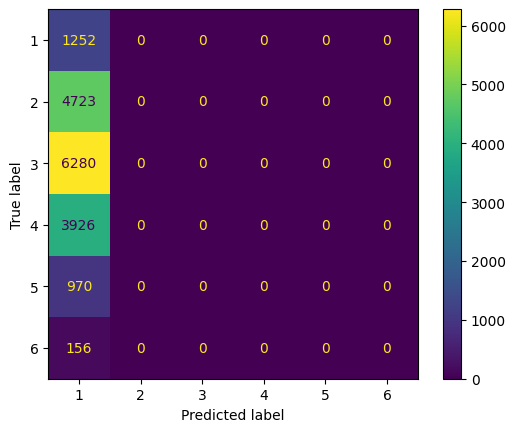

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = data['score'].values
predictions0 = trainer.predict(tokenized_train).predictions
if USE_REGRESSION: predictions = predictions0.round(0) + 1
else: predictions = predictions0.argmax(axis=1) + 1 
cm = confusion_matrix(y_true, predictions, labels=[x for x in range(1,7)])
draw_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=[x for x in range(1,7)])
draw_cm.plot()
plt.show()